# Titanic classification using LightGBM
Solve the Titanic as classification problem with LightGBM  
  
Data: [Titanic: Machine Learning from Disaster | Kaggle](https://www.kaggle.com/c/titanic/data)  
Model: LightGBM

In [1]:
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC

import lightgbm

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
seed_value = 89
random.seed(seed_value)
np.random.seed(seed_value)

In [3]:
data_path = '../../data/titanic'
train_raw = pd.read_csv(os.path.join(data_path, "train.csv"))
# test_raw = pd.read_csv(os.path.join(data_path, "test.csv"))
train_raw, test_raw = train_test_split(train_raw, test_size=0.1, random_state=seed_value)

In [4]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 291 to 811
Data columns (total 12 columns):
PassengerId    90 non-null int64
Survived       90 non-null int64
Pclass         90 non-null int64
Name           90 non-null object
Sex            90 non-null object
Age            73 non-null float64
SibSp          90 non-null int64
Parch          90 non-null int64
Ticket         90 non-null object
Fare           90 non-null float64
Cabin          23 non-null object
Embarked       88 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 9.1+ KB


In [5]:
train_labels = train_raw.pop('Survived')
test_labels = test_raw.pop('Survived')

In [6]:
drop_feature_list = ['PassengerId', 'Name', 'Ticket', 'Cabin']
drop_labels = train_raw.drop(drop_feature_list, axis=1)
test_drop_labels = test_raw.drop(drop_feature_list, axis=1)

In [7]:
train_fill_nan = drop_labels.fillna(drop_labels.median())
test_fill_nan  = test_drop_labels.fillna(drop_labels.median())

### Search categorical data that has missing value
#### 欠損値を持つカテゴリ特徴量を探す

In [8]:
categorical = []

print("---- Missing Values of Train Data ----")
for i in train_fill_nan.columns:
    if train_fill_nan[i].dtype == 'object' and train_fill_nan[i].isnull().any() == True:
        categorical.append(i)
        
print(categorical)


print("---- Missing Values of Train & Test Data ----")
for i in test_fill_nan.columns:
    if test_fill_nan[i].dtype == 'object' and test_fill_nan[i].isnull().any() == True:
        categorical.append(i)
        
print(categorical)

---- Missing Values of Train Data ----
[]
---- Missing Values of Train & Test Data ----
['Embarked']


### Interpolate the missing values with mode value
#### 最頻値を用いて，欠損値の補間

In [9]:
fill_values = {
    'Embarked': train_fill_nan['Embarked'].mode().values[0]
}

train_fill_categorical = train_fill_nan.fillna(fill_values)
test_fill_categorical = test_fill_nan.fillna(fill_values)

In [10]:
train_data = pd.get_dummies(train_fill_categorical)
test_data = pd.get_dummies(test_fill_categorical)

### Split Data
#### Train 用 と Validation 用のデータセットに分割

In [11]:
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, 
                                                                                train_labels,
                                                                                test_size = 0.1,
                                                                                stratify=train_labels,
                                                                                random_state=seed_value
                                                                               )

### Box of each model's results

In [12]:
model_results  = {}

## LightGBM model 

In [13]:
def accuracy(preds, data):
    y_true = data.get_label()
    N_LABELS = 2
    reshaped_preds = preds.reshape(N_LABELS, len(preds) // N_LABELS)
    
    y_pred = np.argmax(reshaped_preds, axis=0)
    acc = np.mean(y_true == y_pred)
    
    return 'accuracy', acc, True

In [14]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'verbose': 2,
    'seed': seed_value
}

evaluation_results = {}

In [15]:
lgbm_train_data = lightgbm.Dataset(train_data, label=train_labels)
lgbm_validation_data = lightgbm.Dataset(validation_data, label=validation_labels, reference=lgbm_train_data)

### Training 

In [16]:
history = lightgbm.train(
    params, 
    lgbm_train_data,
    valid_sets=[lgbm_train_data, lgbm_validation_data],
    valid_names=['Train', 'Validation'],
    evals_result=evaluation_results,
    feval=accuracy,
    num_boost_round=500,
    verbose_eval=20,
    early_stopping_rounds=50
)

Training until validation scores don't improve for 50 rounds.
[20]	Train's multi_logloss: 0.344026	Train's accuracy: 0.872222	Validation's multi_logloss: 0.541238	Validation's accuracy: 0.753086
[40]	Train's multi_logloss: 0.269737	Train's accuracy: 0.902778	Validation's multi_logloss: 0.559097	Validation's accuracy: 0.740741
[60]	Train's multi_logloss: 0.218793	Train's accuracy: 0.913889	Validation's multi_logloss: 0.594013	Validation's accuracy: 0.753086
Early stopping, best iteration is:
[16]	Train's multi_logloss: 0.367465	Train's accuracy: 0.868056	Validation's multi_logloss: 0.542608	Validation's accuracy: 0.765432


In [17]:
train_accuracy = evaluation_results['Train']['accuracy']
valid_accuracy = evaluation_results['Validation']['accuracy']
train_loss = evaluation_results['Train']['multi_logloss']
valid_loss = evaluation_results['Validation']['multi_logloss']

### Plot Training Results

`Point of Marker`  : Best Score

#### Loss

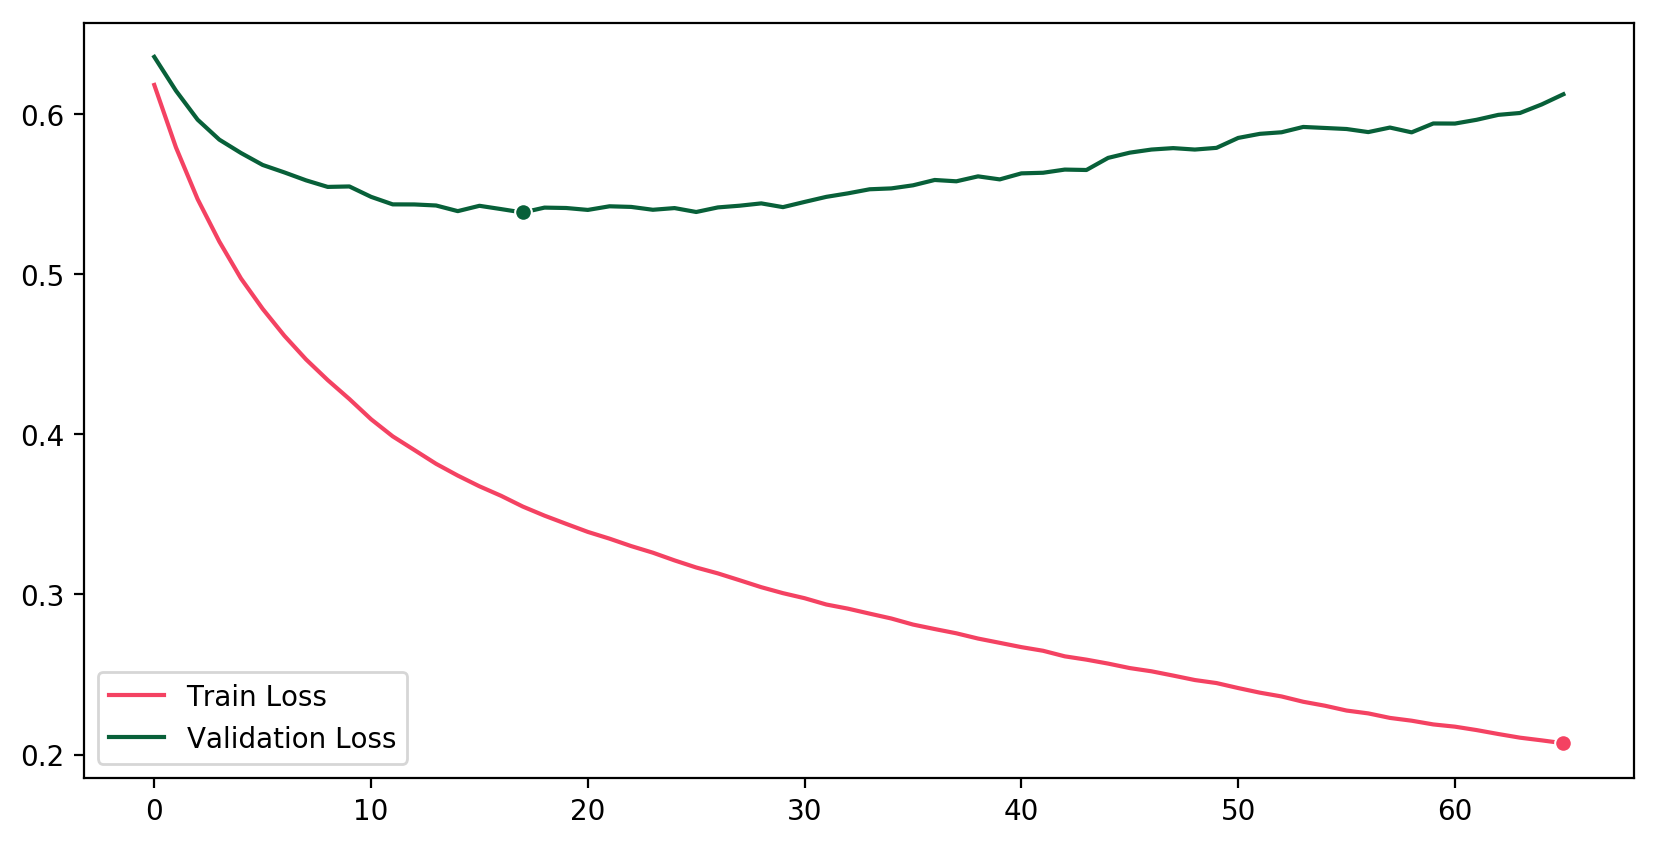

In [18]:
fig = plt.figure(figsize=(10, 5), dpi=200)

sns.lineplot(
    color='#f44262',
    data = np.array(train_loss),
    label = 'Train Loss'
)
sns.lineplot(
    color='#086039',
    data = np.array(valid_loss),
    label = 'Validation Loss'
)


sns.lineplot(
    color='#f44262',
    x = [np.array(train_loss).argmin()],
    y = [np.array(train_loss).min()],
    marker='o',
)
sns.lineplot(
    color='#086039',
    x = [np.array(valid_loss).argmin()],
    y = [np.array(valid_loss).min()],
    marker='o',
)

#### Accuracy

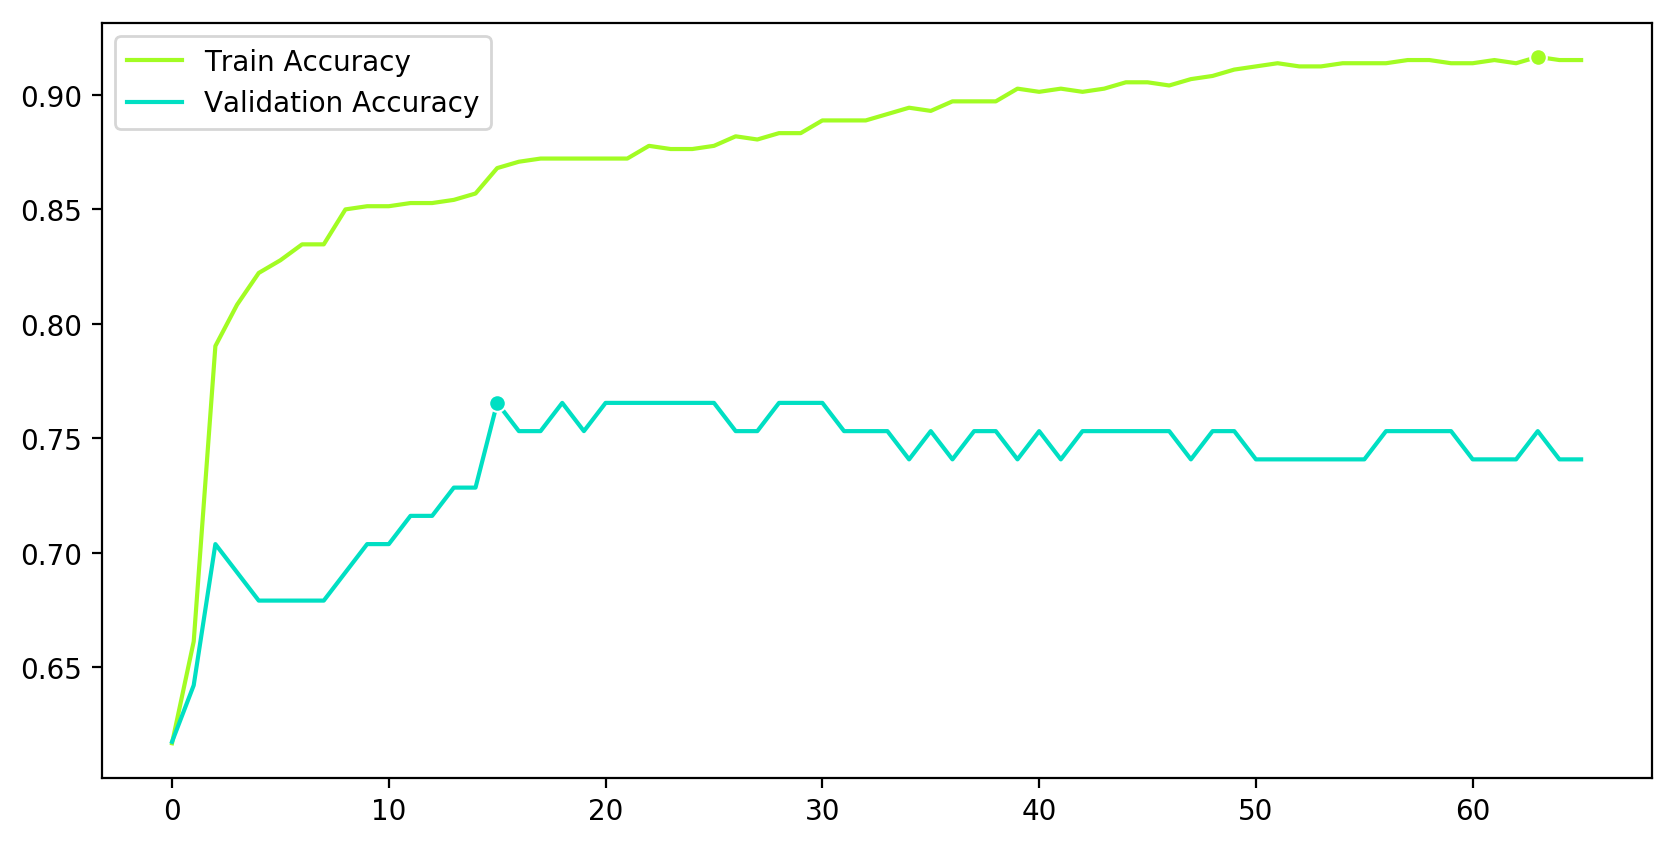

In [19]:
fig = plt.figure(figsize=(10, 5), dpi=200)

sns.lineplot(
    color='#a2fc23',
    data = np.array(train_accuracy),
    label = 'Train Accuracy'
)
sns.lineplot(
    color='#00dfc3',
    data = np.array(valid_accuracy),
    label = 'Validation Accuracy'
)


sns.lineplot(
    color='#a2fc23',
    x = [np.array(train_accuracy).argmax()],
    y = [np.array(train_accuracy).max()],
    marker='o',
)
sns.lineplot(
    color='#00dfc3',
    x = [np.array(valid_accuracy).argmax()],
    y = [np.array(valid_accuracy).max()],
    marker='o',
)

#### Feature Importance

In [20]:
importances  = pd.DataFrame(
    {'features': history.feature_name(),
     'importance': history.feature_importance()
    }
).sort_values('importance', ascending=False)
importances.reset_index(drop=True)

,features,importance
0,Fare,400
1,Age,292
2,Pclass,52
3,Sex_female,32
4,Embarked_S,28
5,SibSp,20
6,Embarked_C,12
7,Parch,8
8,Embarked_Q,2
9,Sex_male,0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

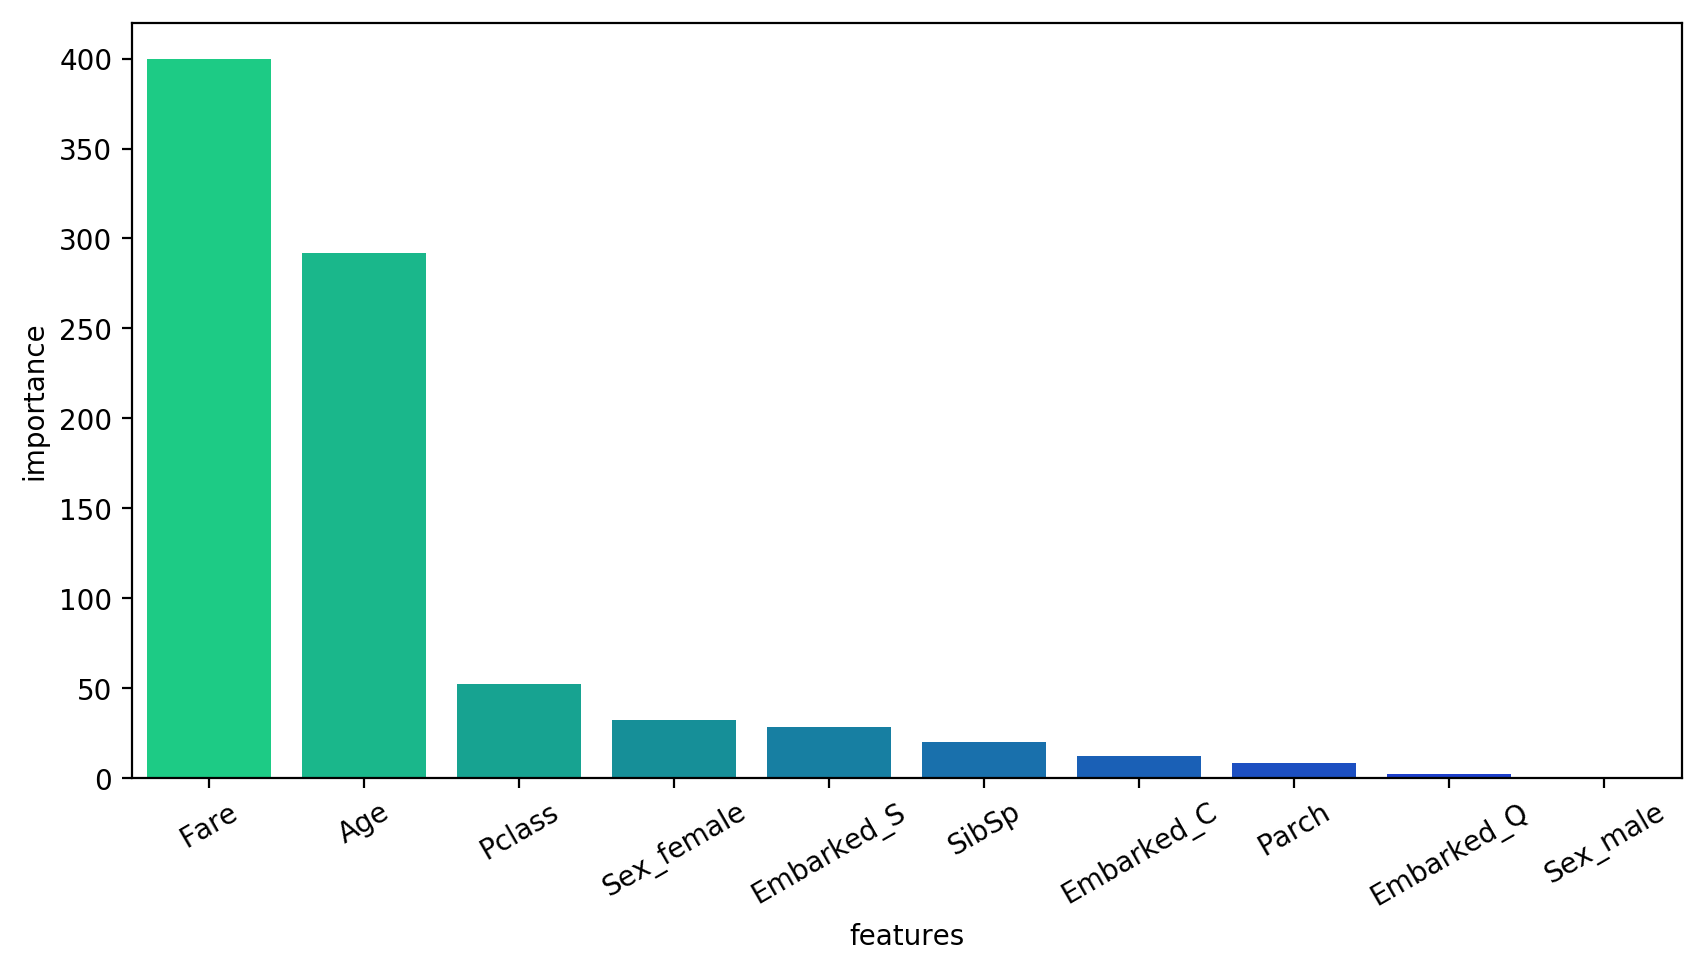

In [21]:
fig = plt.figure(figsize=(10, 5), dpi=200)

sns.barplot(
    x = importances['features'],
    y = importances['importance'],
    palette='winter_r'
)

plt.xticks(rotation=30)

### Create Best Model

In [22]:
best_iteration = history.best_iteration

best_model = lightgbm.train(
    params, 
    lgbm_train_data,
    valid_sets=[lgbm_train_data, lgbm_validation_data],
    valid_names=['Train', 'Validation'],
    evals_result=evaluation_results,
    feval=accuracy,
    num_boost_round=best_iteration,
    verbose_eval=20,
    early_stopping_rounds=50
)

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[16]	Train's multi_logloss: 0.367465	Train's accuracy: 0.868056	Validation's multi_logloss: 0.542608	Validation's accuracy: 0.765432


### Evaluation Test

In [23]:
test_results = pd.DataFrame(best_model.predict(test_data))
test_predicted = pd.DataFrame(np.argmax(test_results.values, axis=1), columns=['Predicted'])
test_df_concat = pd.concat([test_predicted, test_labels.reset_index(drop=True)], axis=1)
test_df_cm = confusion_matrix(test_df_concat['Survived'], test_df_concat['Predicted'])

model_results['lightgbm'] = accuracy_score(test_labels.values, test_predicted.values)

In [24]:
test_df_concat.head()

,Predicted,Survived
0,1,1
1,1,1
2,1,0
3,0,0
4,0,0


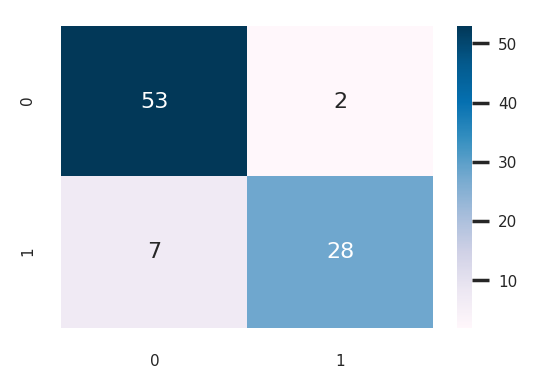

In [25]:
fig = plt.figure(figsize=(3, 2), dpi=200)

sns.set(font_scale=0.5)

sns.heatmap(test_df_cm, annot=True, annot_kws={'size':  8}, cmap='PuBu')

## Compare the Other Algorithm    ※ Hyper Parameters not tuned

### Compare the Support Vector Machine

In [26]:
linear_svm_model = LinearSVC()

In [27]:
lsm_history = linear_svm_model.fit(train_data, train_labels)

In [28]:
lsm_test_results = pd.DataFrame(linear_svm_model.predict(test_data))
lsm_test_predicted = pd.DataFrame(np.argmax(lsm_test_results.values, axis=1), columns=['Predicted'])
lsm_test_df_concat = pd.concat([lsm_test_predicted, test_labels.reset_index(drop=True)], axis=1)
lsm_test_df_cm = confusion_matrix(lsm_test_df_concat['Survived'], lsm_test_df_concat['Predicted'])

model_results['linear_svm'] = accuracy_score(test_labels, lsm_test_predicted)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

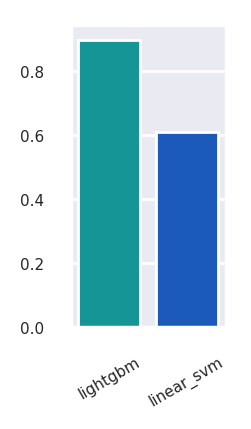

In [29]:
fig = plt.figure(figsize=(1, 2), dpi=200)

sns.set(font_scale=0.5)
sns.barplot(
    x = list(model_results.keys()),
    y = list(model_results.values()),
    palette='winter_r'
)

plt.xticks(rotation=30)

## Classification Task

### Top 1-10 Features 
上位 1 ~ 10の `importances`の特徴のみで学習してみる

In [30]:
results = pd.DataFrame()
for n in range(len(importances)):
    input_data = train_data[importances['features'][0:n+1]]
    linear_svm_model = LinearSVC()
    lin_svc_pipe = Pipeline([('lin_svc_model', linear_svm_model)])
    scores = cross_val_score(lin_svc_pipe, input_data, train_labels,
                            cv=5, scoring='accuracy')
    results = results.append(pd.DataFrame([scores]))
results = results.reset_index(drop=True)

## All Feature
全特徴量を用いた場合

In [31]:
input_data = train_data
linear_svm_model = LinearSVC()
lin_svm_model = LinearSVC()
lin_svc_pipe = Pipeline([('lin_svc_model', linear_svm_model)])
scores = cross_val_score(lin_svc_pipe, input_data, train_labels,
                        cv=5, scoring='accuracy')
results = results.append(pd.DataFrame([scores]))
results = results.reset_index(drop=True)

### Data treatment for plotting
グラフ表示用にデータを整形

In [32]:
label_comp = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'All']
treatment_results = results.T
treatment_results.columns = label_comp

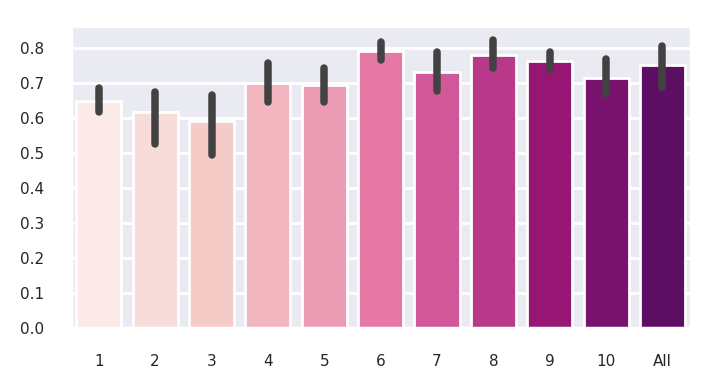

In [33]:
fig = plt.figure(figsize=(4,2), dpi=200)
sns.barplot(data=treatment_results, palette='RdPu')